In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import time
from itertools import permutations, combinations, product, islice
import pandas as pd
from core_enum import fl

## LOAD
df_pte = pd.read_pickle('data/df_gpn_pte')
df_arr = pd.read_pickle('data/df_gpn_seq_motif_0')
dff = df_arr[df_arr['level']=='global']
#
dff = df_arr[df_arr['level']=='global']
dff['fn_comm'] = df_pte['fn_comm'].values
dff.index = dff['prog_id'].values

In [145]:
## get dff for different categories
prog_ids_DB = df_pte[df_pte['d2enumDB']==0]['target'].values
dff_DB = dff[[(x in prog_ids_DB) & (x not in [11]) for x in dff['prog_id'].values]]
dff_iden = dff.loc[df_pte[df_pte['is_iden']==1]['target'].values]
dff_iden = dff_iden.loc[[x for x in dff_iden.index if x not in [236]]] ### remove 236
dff_noniden = dff.loc[df_pte[df_pte['is_iden']==0]['target'].values]

In [146]:
## get motifs for different categories
# {x:motifs_DB.count(x) for x in set(motifs_DB)}
# {x:motifs_all.count(x) for x in set(motifs_all)}

motifs_iden = fl(fl(dff_iden[['motifs']].values))
motifs_noniden = fl(fl(dff_noniden[['motifs']].values))
motifs_DB = fl(fl(dff_DB[['motifs']].values))
#
motifs_all_uniq = list(set(motifs_all))
motifs_iden_uniq = list(set(motifs_iden))
motifs_noniden_uniq = list(set(motifs_noniden))
motifs_DB_uniq = list(set(motifs_DB))
#
motifs_DB_uni = sorted(set(motifs_DB_uniq))
motifs_nonB_uni = sorted(set(motifs_iden_uniq) - set(motifs_DB_uniq))
motifs_noniden_uni = sorted(set(motifs_noniden_uniq) - set(motifs_DB_uniq))

# replace 'w' with 'ŵ'
motifs_DB_uni_varw = [''.join([(y,'ŵ')[(y=='w')*1] for y in x]) for x in motifs_DB_uni]
motifs_nonB_uni_varw = [''.join([(y,'ŵ')[(y=='w')*1] for y in x]) for x in motifs_nonB_uni]

In [147]:
## print for venn diagram
n_iden = len(motifs_iden_uniq)
n_noniden = len(motifs_noniden_uniq)
n_all = len(set(motifs_iden_uniq).union(set(motifs_noniden_uniq)))
n_intersec = len(set(motifs_iden_uniq).intersection(set(motifs_noniden_uniq)))
n_DB = len(motifs_DB_uni)
print('n_all:', n_all)
print('n_iden:', n_iden)
print('n_noniden:', n_noniden)
print('n_intersec:', n_intersec)
print('n_DB:', n_DB)
print('n_iden_exclusive:', n_iden-n_intersec)
print('n_noniden_exclusive:', n_noniden-n_intersec)
#
n_inenProg = len(dff_iden)
n_DBProg = len(dff_DB)
n_remainingProg = len(dff_noniden) - 63 # there are 64 uniden DB, we substract only 63 for classifying prog 11 as noniden rather than DB
print('')
print('n_inenProg:', n_inenProg)
print('n_DBProg:', n_DBProg)
print('n_remainingProg:', n_remainingProg)
#
rate_noniden = (n_noniden-n_intersec) / n_remainingProg
rate_iden = (n_iden-n_intersec) / n_inenProg
print('')
print('rate_noniden:', rate_noniden)
print('rate_iden:', rate_iden)
print('ratio:', rate_iden/rate_noniden)

n_all: 292
n_iden: 188
n_noniden: 220
n_intersec: 116
n_DB: 22
n_iden_exclusive: 72
n_noniden_exclusive: 104

n_inenProg: 561
n_DBProg: 64
n_remainingProg: 3840

rate_noniden: 0.027083333333333334
rate_iden: 0.12834224598930483
ratio: 4.738790621143563


In [148]:
## dichotomize iden motifs into DB and nonDB
dff_iden['motifs_DB_excl'] = [[y for y in x if y not in motifs_DB_uniq] for x in dff_iden['motifs'].values]
dff_iden['motifs_DB'] = [[y for y in x if y in motifs_DB_uniq] for x in dff_iden['motifs'].values]

## get ratio matrix
fn_comm_arr = dff_iden['fn_comm'].values
tot_arr = np.array([fn_comm_arr.tolist().count(x) for x in np.unique(fn_comm_arr)])
#
motifs_nonB_arr = np.array([[(y in x)*1 for x in dff_iden['motifs_DB_excl'].values] for y in motifs_nonB_uni])
count_arr = np.array([[fn_comm_arr[np.where(y==1)].tolist().count(x) for x in np.unique(fn_comm_arr)] for y in motifs_nonB_arr])
ratio_arr = count_arr/tot_arr[None]
#
motifs_DB_arr = np.array([[(y in x)*1 for x in dff_iden['motifs_DB'].values] for y in motifs_DB_uni])
count_arr_DB = np.array([[fn_comm_arr[np.where(y==1)].tolist().count(x) for x in np.unique(fn_comm_arr)] for y in motifs_DB_arr])
ratio_arr_DB = count_arr_DB/tot_arr[None]

In [171]:
## create df for 188 iden motifs
p_arr = ratio_arr/ratio_arr.sum(-1)[:,None]
p_arr_DB = ratio_arr_DB/ratio_arr_DB.sum(-1)[:,None]
clusters = ratio_arr.argmax(-1)
clusters_DB = ratio_arr_DB.argmax(-1)

# compute speicificity
def gen_specificity(p, n_cat=9):
    categorical_entropy = -(p*np.log(p+1e-16)/np.log(n_cat)).sum(-1)
    return 1 - categorical_entropy

specificities = np.array([gen_specificity(p) for p in p_arr])
specificities_DB = np.array([gen_specificity(p) for p in p_arr_DB])

# df
query = []
for x,y,z,w,q in zip(motifs_DB_uni, clusters_DB, ratio_arr_DB, count_arr_DB, specificities_DB): query.append([x,y,z,w.max(),q,1])
for x,y,z,w,q in zip(motifs_nonB_uni, clusters, ratio_arr, count_arr, specificities): query.append([x,y,z,w.max(),q,0])
df_motifs_idenProg = pd.DataFrame(query, columns=['motif','fn_comm','ratio','count','specificity','is_DB']).sort_values(['fn_comm','is_DB','specificity','count'], ascending=[True, False, True, True])
df_motifs_idenProg.index = range(len(df_motifs_idenProg))

In [172]:
motifs_DB_uni

['L',
 'LLW',
 'LLlLlW',
 'LW',
 'LWLll',
 'LWl',
 'LWll',
 'Ll',
 'LlLlW',
 'LlW',
 'LlWWl',
 'LlWl',
 'Lll',
 'LllW',
 'LllWW',
 'Lllll',
 'W',
 'WWl',
 'WWll',
 'Wl',
 'Wll',
 'l']

In [173]:
len(df_pte[df_pte['fn_comm']==0])

26

In [176]:
df_motifs_idenProg

,motif,fn_comm,ratio,count,specificity,is_DB
0,LllW,0,"[0.3076923076923077, 0.0, 0.07692307692307693,...",21,0.372976,1
1,LllWW,0,"[0.2692307692307692, 0.0, 0.008547008547008548...",7,0.856454,1
2,Lwl,0,"[0.5, 0.0, 0.3333333333333333, 0.4823529411764...",41,0.185550,0
3,w,0,"[0.2692307692307692, 0.1, 0.23931623931623933,...",28,0.302951,0
4,LwwW,0,"[0.038461538461538464, 0.0, 0.0341880341880341...",4,0.374812,0
...,...,...,...,...,...,...
183,LLlwlLl,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...",7,1.000000,0
184,LLWlLl,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111...",9,1.000000,0
185,LWLl,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.160...",13,1.000000,0
186,LLlLWl,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.185...",15,1.000000,0


In [187]:
## all motifs sort by count
# pd.DataFrame.from_dict({x:fl(dff_DB['motifs'].values).count(x) for x in motifs_DB_uni}, orient='index', columns=['count']).sort_values('count', ascending=False)
#
df_motifs_idenProg[(df_motifs_idenProg['is_DB']==0) & (df_motifs_idenProg['fn_comm']==8)].sort_values('count', ascending=False)[['fn_comm','motif','count','is_DB']][30:]

,fn_comm,motif,count,is_DB
170,8,LwwlW,1,0
169,8,LlwWW,1,0
167,8,LWlWLl,1,0
148,8,LLWLWW,1,0
156,8,LLlwwl,1,0
149,8,LLWlLWl,1,0
150,8,LLWlLlW,1,0
151,8,LLWlWl,1,0
152,8,LLlLWLl,1,0
153,8,LLlLwW,1,0


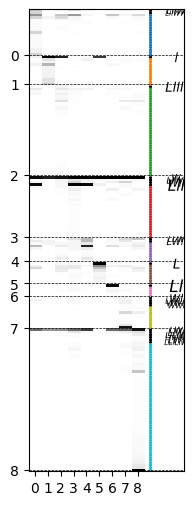

In [143]:
## PLOT: ratio matrix
idx_group = [df_motifs_idenProg[df_motifs_idenProg['fn_comm']==i_group].index[-1] for i_group in np.unique(df_motifs_idenProg['fn_comm'])]
idx_DB = df_motifs_idenProg[df_motifs_idenProg['is_DB']==1].index.values
motifs_DB = df_motifs_idenProg[df_motifs_idenProg['is_DB']==1]['motif'].values

dfff = df_motifs_idenProg[df_motifs_idenProg['is_DB']==0]
idx_nonB = dfff.index.values
clusters_nonB = dfff['fn_comm'].values

ratio_arr_all = np.stack(df_motifs_idenProg['ratio'].values)
plt.figure(figsize=(2,6), dpi=100)
plt.imshow(ratio_arr_all, aspect='auto', cmap='Greys', interpolation='nearest')
#
if True:
    plt.scatter([9]*len(idx_DB), idx_DB, s=5, c='k', marker='o', edgecolors='none')
    for i, motif in zip(idx_DB, motifs_DB): plt.scatter([11], [i], s=len(motif)*50, c='k', marker='$%s$'%motif, edgecolors='none')
    #
    plt.scatter([9]*len(idx_nonB), idx_nonB, s=5, c=np.array(colors)[clusters_nonB], marker='o', edgecolors='none')
for y in idx_group: plt.axhline(y, color='k', linestyle='--', linewidth=.5)
plt.yticks(idx_group, df_motifs_idenProg.loc[idx_group]['fn_comm'])
plt.xticks(df_motifs_idenProg.loc[idx_group]['fn_comm'])
plt.savefig('fig/resub_polar_matrix.pdf')

[100.          53.84615385   7.69230769   7.69230769   7.69230769
   7.69230769  15.38461538  53.84615385   7.69230769   7.69230769
   7.69230769   7.69230769   7.69230769   7.69230769  23.07692308
  23.07692308  53.84615385]
[40. 20. 80. 20. 20. 20. 20. 20. 40. 40. 60.]
[32.47863248 10.25641026 23.93162393 10.25641026 15.38461538 42.73504274
  3.41880342 10.25641026 11.96581197  5.12820513  6.83760684  1.70940171
  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171
  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171
  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171  1.70940171
  1.70940171  3.41880342  5.12820513  5.12820513  6.83760684  6.83760684]
[16.47058824 28.23529412  7.05882353  9.41176471  2.35294118 11.76470588
  2.35294118  4.70588235  2.35294118  2.35294118  2.35294118  2.35294118
  2.35294118  2.35294118  2.35294118  2.35294118  2.35294118  2.35294118
  4.70588235  4.70588235  7.05882353]
[ 33.33333333 177.77777778  27.7

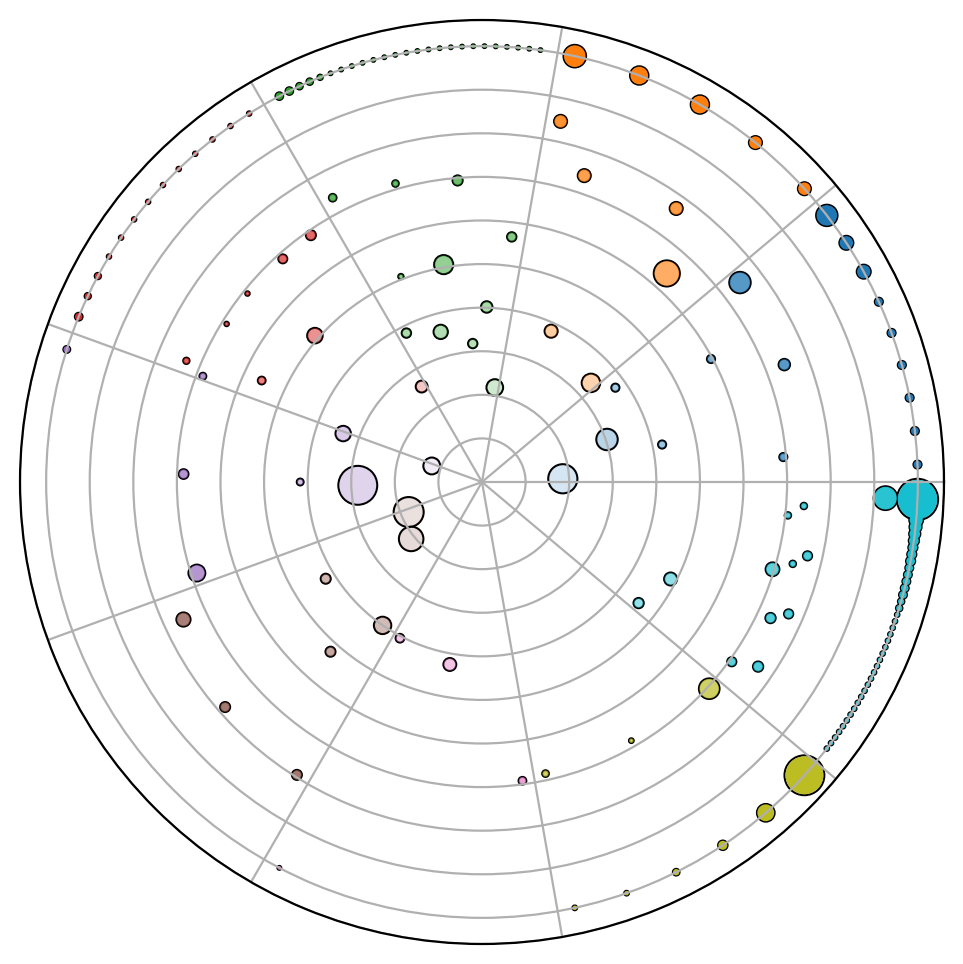

In [142]:
# v2
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
marker_size = 200
size_all = ratio_arr.max(-1) * marker_size

fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111, projection='polar')
angle_dict = {}
for i_group in range(9):
    # idx_group = np.where(clusters==i_group)[0]
    dff = df_motifs_idenProg[(df_motifs_idenProg['is_DB']==0) & (df_motifs_idenProg['fn_comm']==i_group)]
    #
    specific_group = dff['specificity'].values
    ratio_group = np.stack(dff['ratio'].values).max(-1)
    sizes = ratio_group * marker_size
    #
    n_spec_0 = np.where(specific_group<1)[0].shape[0]
    n_spec_1 = np.where(specific_group==1)[0].shape[0]
    dtheta = marker_size/5e3
    angles_0 = np.linspace(2*dtheta, 6*np.pi/9, n_spec_0) % (2*np.pi/9) + 2*np.pi/9 * i_group - dtheta
    angles_1 = np.linspace(2*np.pi/9*i_group+dtheta, 2*np.pi/9*(i_group+1)-dtheta, n_spec_1)
    angles = np.hstack([angles_0, angles_1])
    angle_dict.update({x:y for x,y in zip(dff.index.values, angles)})
    #
    print(sizes)
    ax.scatter(angles, specific_group, s=sizes*1.1, edgecolors='k', linewidths=.75, zorder=0, c='none')
    ax.scatter(angles, specific_group, s=sizes, edgecolors='none', c=colors[i_group], zorder=1, alpha=specific_group)
    #
ax.set_xticks(np.linspace(0, 2*np.pi, 9, endpoint=False))
ax.set_yticks(np.linspace(0, 1, 11).tolist()+[1.06])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('fig/resub_polar.pdf', dpi=300)

0.04
0.32777072891331366
0.6155414578266272
0.20518048594220908
0.4929512148555228
0.08259024297110454
0.37036097188441836
0.6581317007977316
0.04
0.11726646259971646
0.19453292519943294
0.27179938779914936
0.34906585039886584
0.4263323129985823
0.5035987755982988
0.5808652381980153
0.6581317007977318
0.7381317007977317
1.1410107212763707
0.845758040957278
1.2486370614359172
0.9533843811168244
1.3562634015954633
0.7381317007977318
0.8926646259971648
1.0471975511965976
1.2017304763960306
1.3562634015954635
1.4362634015954636
1.637702911834783
1.8391424220741026
2.040581932313422
1.54388974175501
1.7453292519943293
1.9467687622336491
1.4500765716752366
1.6515160819145562
1.8529555921538758
2.0543951023931952
1.4362634015954636
1.4620188891287025
1.4877743766619413
1.51352986419518
1.5392853517284188
1.5650408392616577
1.5907963267948966
1.6165518143281354
1.642307301861374
1.668062789394613
1.6938182769278518
1.7195737644610907
1.7453292519943293
1.7710847395275682
1.796840227060807
1.82

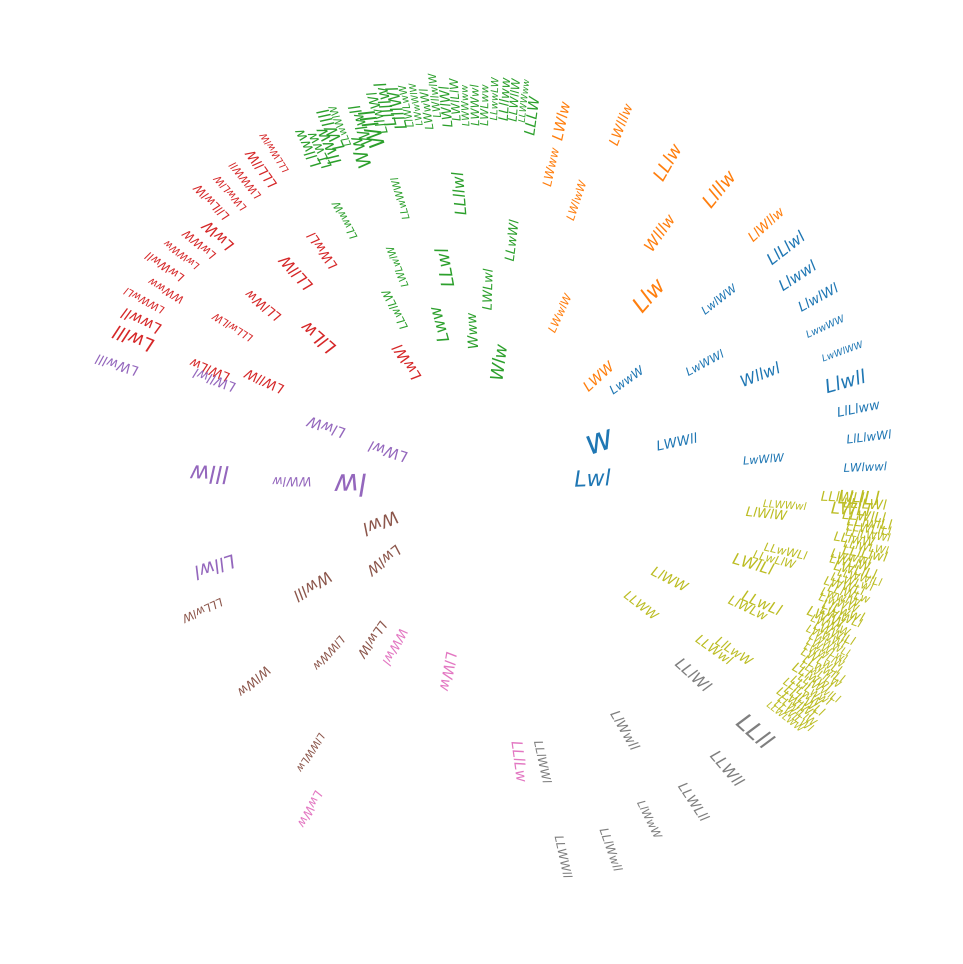

In [93]:
'''
mod var w
'''

import matplotlib as mpl
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111, projection='polar')
dfff = df_motifs_idenProg[df_motifs_idenProg['is_DB']==0]
for i, motif, spec, i_group in zip(dfff.index.values, dfff['motif'].values, dfff['specificity'].values, dfff['fn_comm'].values):
    angle = angle_dict[i]
    print(angle)
    #
    t = mpl.markers.MarkerStyle(marker='$%s$'%motif)
    t._transform = t.get_transform().rotate_deg(angle/2/np.pi*360)

    size = 100*len(motif)**.5
    ax.scatter([angle], [spec + size*1e-3], s=size, edgecolors='none', c=colors[i_group], marker=t, zorder=1)
    #
ax.set_xticks(np.linspace(0, 2*np.pi, 9, endpoint=False))
ax.set_yticks(np.linspace(0, 1.5, 11).tolist()+[1.06])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.axis('off')
plt.savefig('fig/resub_polar_wslg.pdf', dpi=300)

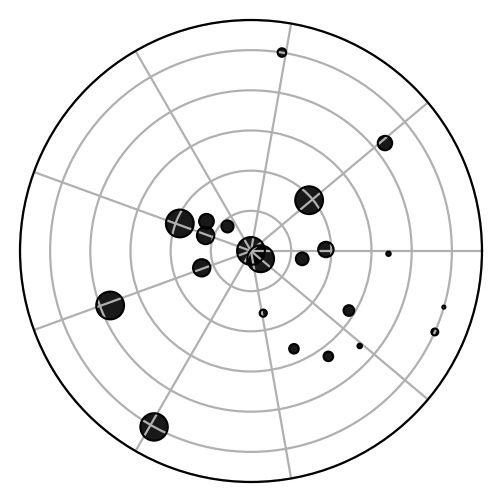

In [94]:
# v2 DB
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
marker_size = 100
size_all = ratio_arr_DB.max(-1) * marker_size

fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(111, projection='polar')
angle_dict_DB = {}
for i_group in range(9):
    # i_group = 8
    idx_group = np.where(clusters_DB==i_group)[0]
    count_group = count_arr_DB[idx_group, i_group]
    specific_group = specificities_DB[idx_group]
    idx_sort = specific_group.argsort()
    specific_group = specific_group[idx_sort]
    sizes = size_all[idx_group[idx_sort]]
    #
    angles = np.linspace(2*np.pi/9*i_group+marker_size/5e3, 2*np.pi/9*(i_group+1)-marker_size/5e3, len(specific_group))
    angles = np.hstack([angles[::4], angles[1::4], angles[2::4], angles[3::4]])
    angle_dict_DB.update({x:y for x,y in zip(idx_group[idx_sort], angles)})
    #
    ax.scatter(angles, specific_group, s=sizes, edgecolors='k', linewidths=.75, c='none', zorder=2)
    ax.scatter(angles, specific_group, s=sizes, edgecolors='none', c='k', zorder=1, alpha=.9)
    #
ax.set_xticks(np.linspace(0, 2*np.pi, 9, endpoint=False))
ax.set_yticks(np.linspace(0, 1, 6).tolist()+[1.15])
ax.set_xticklabels([])
ax.set_yticklabels([])
# plt.axis('off')
plt.savefig('fig/resub_polar_DB.pdf', dpi=300)

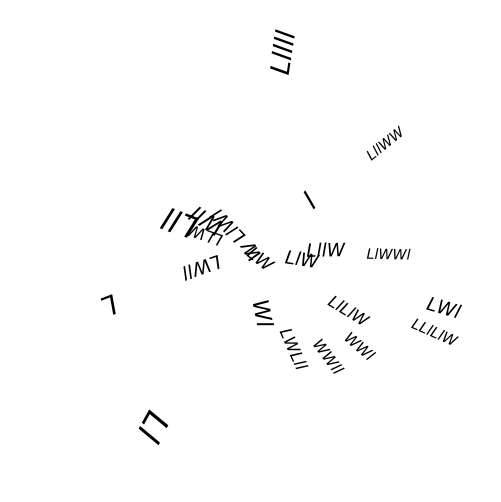

In [96]:
import matplotlib as mpl
fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(111, projection='polar')
for i, motif in enumerate(motifs_DB_uni):
    specific = specificities_DB[i]
    angle = angle_dict_DB[i]
    #
    t = mpl.markers.MarkerStyle(marker='$%s$'%motif)
    t._transform = t.get_transform().rotate_deg(angle/2/np.pi*360)

    size = 50*len(motif)**1
    ax.scatter([angle], [specific + 0*size*1e-3], s=size, edgecolors='none', c='k', marker=t, zorder=1)
    #
ax.set_xticks(np.linspace(0, 2*np.pi, 9, endpoint=False))
ax.set_yticks(np.linspace(0, 1, 6).tolist()+[1.15])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.axis('off')
plt.savefig('fig/resub_polar_wslg_DB.pdf', dpi=300)